In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from os import system
from math import exp
import numpy as np
from copy import deepcopy
from tqdm.notebook import tqdm

In [2]:
# Read data 1

data1 = pd.read_csv("chips.csv")
data1

,x,y,class
0,0.051267,0.699560,P
1,-0.092742,0.684940,P
2,-0.213710,0.692250,P
3,-0.375000,0.502190,P
4,-0.513250,0.465640,P
...,...,...,...
113,-0.720620,0.538740,N
114,-0.593890,0.494880,N
115,-0.484450,0.999270,N
116,-0.006336,0.999270,N


In [3]:
# Read data 2

data2 = pd.read_csv("geyser.csv")
data2

,x,y,class
0,1,4.4,N
1,1,3.9,N
2,1,4.0,P
3,1,4.0,N
4,1,3.5,N
...,...,...,...
217,23,2.1,P
218,23,4.2,N
219,23,2.1,P
220,23,5.2,N


In [4]:
# Convert to arrays

def convert_classes(c):
    ans = []
    for i in c:
        if i == 'N':
            ans.append(-1)
        else:
            ans.append(1)
    return ans
    
classes = []
attributes = []

classes.append(convert_classes(data1["class"].values))
attributes.append(data1.drop("class", axis=1).values)

classes.append(convert_classes(data2["class"].values))
attributes.append(data2.drop("class", axis=1).values)

In [5]:
%cat "E.cpp"

#include <iostream>
#include <vector>
#include <cmath>
#include <algorithm>
#include <random>
#include <ctime>
#include <iomanip>
#include <cassert>
using namespace std;

using vecd = vector<long double>;
using rvecd = const vector<long double> &;

vector<vector<long double>> K;
vector<long long> Y;
long double C;

void in() {
  int N; cin >> N;
  K.resize(N); Y.resize(N);

  for (int i = 0; i < N; ++i) {
    K[i].resize(N);
    for (int j = 0; j < N; ++j) {
      cin >> K[i][j];
    }
    cin >> Y[i];
  }

  cin >> C;
}

void out(rvecd ans) {
  cout << fixed << setprecision(20);
  for (auto i : ans) {
    cout << i << "\n";
  }
}

void out_debug(rvecd ans) {
  cout << fixed << setprecision(20);
  for (auto i : ans) {
    cout << i << " ";
  }
  cout << endl;
}

long double count_without_b(rvecd ans, int i) {
  long double a = 0.0;
  for (size_t j = 0; j < K.size(); ++j) {
    a += K[j][i] * Y[j] * ans[j];
  }
  return a;
}

void out_stat(rvecd ans) {
  size_t good = 0;
  for (size_t i

In [6]:
# Using SMO from E.cpp

def smo_cpp(K, Y, C):
    input_file = "input.txt"
    output_file = "output.txt"
    execute = "./E"

    f = open(input_file, "w")
    N = len(K)
    f.write(str(N) + "\n")
    for i in range(N):
        for j in K[i]:
            f.write(str(j) + " ")
        f.write(str(Y[i]) + "\n")
    f.write(str(C))
    f.close()
    
    system("cat " + input_file + " | " + execute + " > " + output_file)
    
    f = open(output_file, "r")
    output = f.read()
    f.close()
    
    return [float(x) for x in output.split()]

In [7]:
# Get kernel matrix

def get_K(src, f):
    N = len(src)
    ans = [[0.0 for i in range(N)] for i in range(N)]
    for i in range(N):
        for j in range(N):
            ans[i][j] = f(src[i], src[j])
    return ans

In [8]:
# Get kernel functions

def get_kernel_functions():
    ans = []
    ans.append({"C": 0.1, "name": "linear", "func": lambda x, y: x[0] * y[0] + x[1] * y[1]})
    ans.append({"C": 10.0, "name": "poly", "func": lambda x, y: (x[0] * y[0] + x[1] * y[1]) ** 3})
    ans.append({"C": 0.5, "name": "gauss", 
                 "func": lambda x, y: exp(-5 * ((x[0] - y[0]) ** 2 + (x[1] - y[1]) ** 2))})
    return ans
    for C in [0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]:
        f = {}
        f["C"] = C
        
        f["name"] = "linear"
        f["func"] = lambda x, y: x[0] * y[0] + x[1] * y[1]
        ans.append(deepcopy(f))
        
        f["name"] = "poly"
        for d in [2, 3, 4, 5]:
            f["param"] = d
            f["func"] = lambda x, y: (x[0] * y[0] + x[1] * y[1]) ** d
            ans.append(deepcopy(f))
        
        f["name"] = "gauss"
        for b in [1, 2, 3, 4, 5]:
            f["param"] = b
            f["func"] = lambda x, y: exp(-b * ((x[0] - y[0]) ** 2 + (x[1] - y[1]) ** 2))
            ans.append(deepcopy(f))
    return ans;

In [22]:
# Predicted

def get_predicted(c, K, l):
    u = 0.0
    for j in range(len(K)):
        u += c[j] * l[j] * K[j]
    return u + l[-1]

def get_predicted2(c, a, l, f, attrs):
    u = 0.0
    for j in range(len(c)):
        u += c[j] * l[j] * f(a, attrs[j])
    return u + l[-1]

In [10]:
# Get stat

def get_stat(a, c):
    funcs = get_kernel_functions()
    best = {}
    N = len(a)
    for f in tqdm(funcs):
        t = 0
        K = get_K(a, f["func"])
        for i in range(N):
            save_c = c[i]
            new_c = np.delete(c, i, axis=0)
            
            new_k = np.delete(K, i, axis=1)
            save_k = new_k[i]
            new_k = np.delete(new_k, i, axis=0)
            lambdas = smo_cpp(new_k, new_c, f["C"])
            p = get_predicted(new_c, save_k, lambdas)
            
            if p * save_c > 0.0:
                t += 1
        acc = t / N
        s = best.get(f["name"])
        if s == None or s["acc"] < acc:
            best[f["name"]] = {
                "func": f,
                "acc": acc,
                "lambdas": smo_cpp(K, c, f["C"])
            }
    return best

In [11]:
# Count stat

# stat_chips = get_stat(attributes[0], classes[0])
stat_geyser = get_stat(attributes[1], classes[1])

In [12]:
def show_best(stat):
    for s in stat:
        copy = deepcopy(stat[s])
        del copy["func"]["func"]
        print(str(copy["func"]) + ": acc = " + str(copy["acc"]))

In [13]:
print("For chips:")
#show_best(stat_chips)

print("For geyser:")
show_best(stat_geyser)

For chips:
For geyser:
{'C': 0.1, 'name': 'linear'}: acc = 0.8918918918918919
{'C': 10.0, 'name': 'poly'}: acc = 0.6621621621621622
{'C': 0.5, 'name': 'gauss'}: acc = 0.8198198198198198


In [31]:
def draw(a, c, stat, step):
    x_max, y_max = np.amax(a, 0)
    x_min, y_min = np.amin(a, 0)
    
    X, Y = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, 0.01))
    AX   = np.apply_along_axis(lambda s: get_predicted2(c, s, stat["lambdas"], stat["func"]["func"], a),
                               1, np.c_[X.ravel(), Y.ravel()])

    x_0, x_1 = np.array([]), np.array([])
    y_0, y_1 = np.array([]), np.array([])
    for i in range(len(a)):
        if c[i] == -1:
            x_0, y_0 = np.append(x_0, a[i][0]), np.append(y_0, a[i][1])
        else:
            x_1, y_1 = np.append(x_1, a[i][0]), np.append(y_1, a[i][1])
    
    plt.figure(figsize=(12, 12))
    plt.xlim(x_min, x_max), plt.ylim(y_min, y_max)
    plt.pcolormesh(X, Y, np.array(AX).reshape(X.shape),
                   cmap=ListedColormap(['#799FE1', '#FC9797']), shading="auto")
    plt.scatter(x_0, y_0, color='blue', s=50)
    plt.scatter(x_1, y_1, color='red',  s=50)
    
    plt.show()

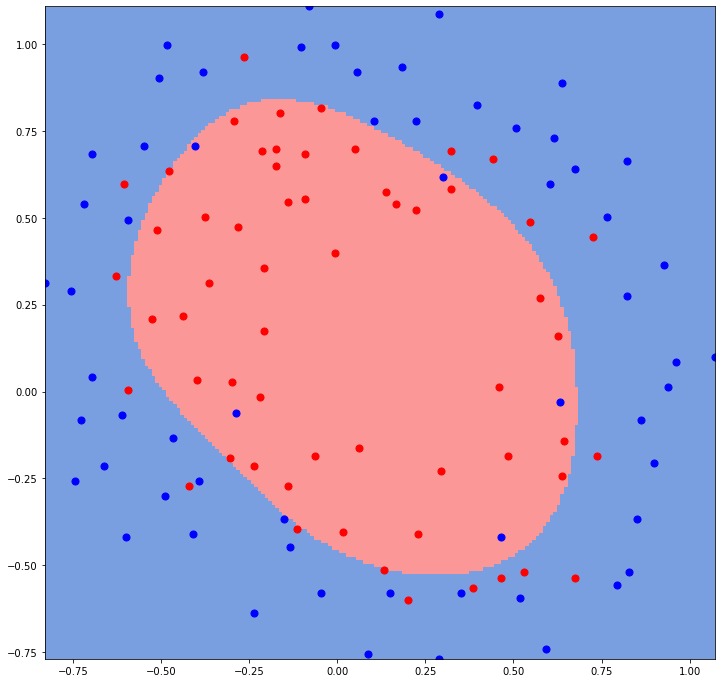

In [15]:
#draw(attributes[0], classes[0], stat_chips["gauss"], 0.01)

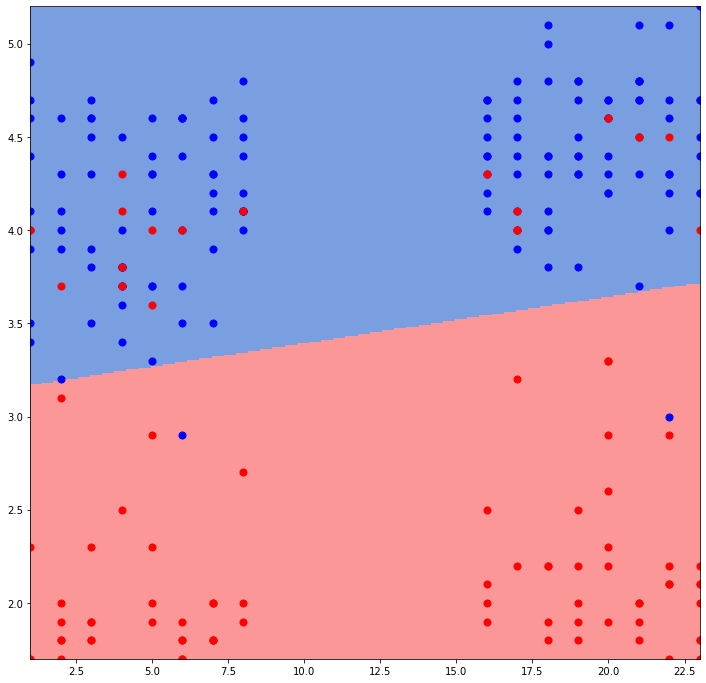

In [34]:
draw(attributes[1], classes[1], stat_geyser["linear"], 0.05)

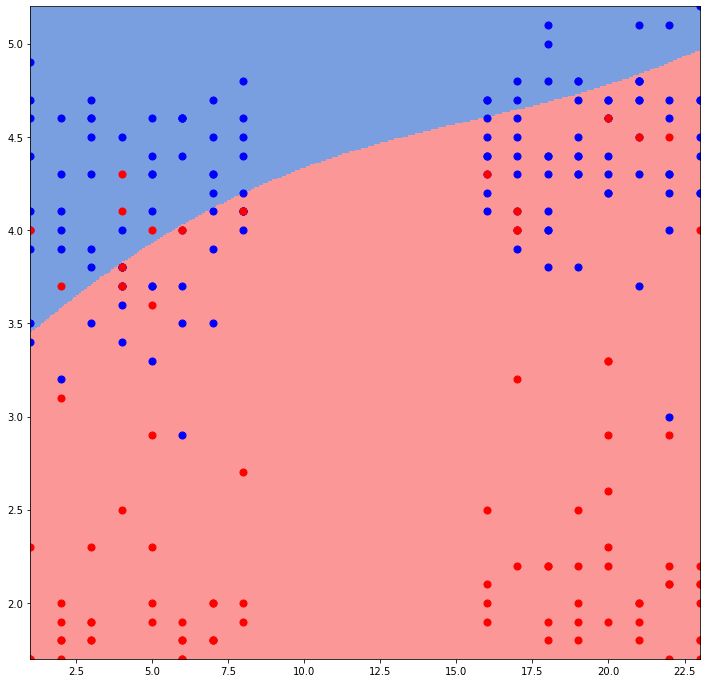

In [33]:
draw(attributes[1], classes[1], stat_geyser["poly"], 0.05)

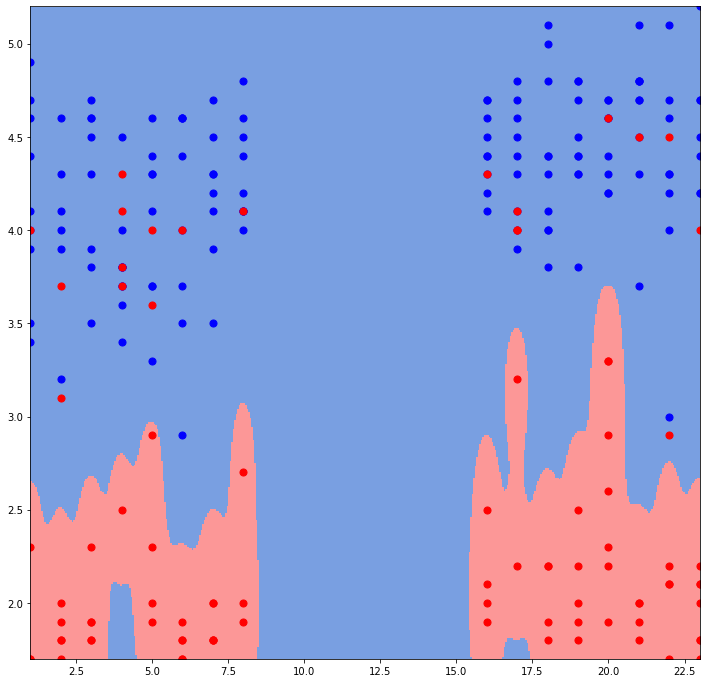

In [35]:
draw(attributes[1], classes[1], stat_geyser["gauss"], 0.05)